# Longitudinal Connectomes Analysis

Supporting code for
> Óscar Peña-Nogales, Timothy M. Ellmore, Rodrigo de Luis-García, Jessika Suescun, Mya C. Schiess and Luca Giancardo. Longitudinal Connectomes as a Candidate Progression Marker for Prodromal Parkinson's Disease. (under review)


The first half of the notebook replicates the longitudinal connectome analysis on connectivity metrics derived from the PPMI dataset. We aim to identify and quantify a longitudinal degenerative Parkinson's disease pattern from the diffusion magnetic resonance imaging connectivity information that can be found in a de novo early Parkinson's disease cohort (n=21) and in a cohort at high risk of being in the Parkinson's disease prodromal phase (n=16) that was not present in cohort matched Controls (n=30). This progression pattern was numerically quantified with a longitudinal brain connectome progression score. This score is generated by an interpretable machine learning algorithm trained, with cross-validation, on the longitudinal connectivity information of Parkinson's disease and Control groups computed on a nigrostriatal pathway-specific parcellation atlas. 

The second half computes statistical tests and comparison with the clinical metrics. I order to run this analysis you will have to request access to the PPMI dataset and change the following parameters in the configuration.json file

> "DIR_PPMI_IMGS": "raw images location", (optional)

> "DIR_PPMI_CLIN_INFO": "clinical PPMI data location"

In [1]:
#imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle as pk
import gzip
import sys

import utils
import utilsStats
import statsmodels.api as sm

import copy
import sklearn.metrics as met

# set Seaborn appearance
import seaborn as sns
sns.set_context("notebook", font_scale=1.5  ) 
sns.set_style("whitegrid")


import mlconn.conn_utils as conn_utils
import mlconn.temporal_conn as t_conn


# Load configuration
CONF_FILE = 'data/configuration.json'
CONF = utils.readConf(CONF_FILE)

%matplotlib inline

In [47]:
# relaunch this cell if custom modules are edited
reload(utils)
reload(conn_utils)
reload(t_conn)

<module 'mlconn.temporal_conn' from 'mlconn/temporal_conn.pyc'>

# Generate Dataset

In [3]:
# node names
connFr = conn_utils.getFSnodes(CONF['PD25_NODES'])

# GT
if os.path.exists( CONF['SUBJ_MATCHED_INFO'] ):
    imgInfoFr2 = pd.read_csv( CONF['SUBJ_MATCHED_INFO'], index_col='Subject' )
    # convert columns to datetime
    imgInfoFr2.adate = imgInfoFr2.adate.astype('datetime64')
    imgInfoFr2.adate_lst  = imgInfoFr2.adate_lst.astype('datetime64')
    
else:
    # load and match candidates
    imgInfoFr = t_conn.getImgInfoFL(CONF['SUBJ_FULL_INFO'])
    imgInfoFr2 = imgInfoFr.copy()

    # keep only subject with multiple visits (use "Visit" field to compute and remove people with visit 0)
    lblMulVis = (imgInfoFr2.daysDiff > 0)
    imgInfoFr2 = imgInfoFr2[lblMulVis]
    # remove images not analysable
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3859]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3572]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3811]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3360]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3105]

    # store 
    imgInfoFr2.to_csv( CONF['SUBJ_MATCHED_INFO'], index=True )
    

# copy filtered 
imgInfoFr2full = imgInfoFr2.copy()

# Generate feature matrix and labels

In [4]:
#================================= Gen Feature Matrix
def genFeatMat( imgInfoFrIn, colNameIn='fsName' ):
    """
    Generate feature matrix and labels from imgInfoFr
    return (X->feature matrix ,y->labels)
    """

    # create feature vector/GT
    X = [] 
    y = []
    for i in range(len(imgInfoFrIn)):
        try:

            # all connectomes to be merged
            connDic = {'1': '2_connectomeLocal_ShiftTrim.csv','2': '2_FaconnectomeLocalFSL_ShiftTrim.csv','3': '2_AdcconnectomeLocalFSL_ShiftTrim.csv'}
            connVec=[]
            for conn in connDic:
                # connectome info 
                connArr = conn_utils.loadConnectome(imgInfoFrIn, i,connName=connDic[conn], baseDir=CONF['DIR_CONNECTOMES'], colName=colNameIn)
                conn_oneVec = conn_utils.compConnVec(connArr)

                # Merge all the features into the same vector
                connVec=np.concatenate((conn_oneVec,connVec), axis=0)
            
            X.append( connVec )

            y.append( imgInfoFrIn.iloc[i]['GT'] )
        except:
            print 'error:', imgInfoFrIn.iloc[i][colNameIn]
    # convert to numpy
    X = np.array(X)
    y = np.array(y)
    return (X,y)

def genFeatDeltaMat( imgInfoFrIn, colNameDelta=['fsName', 'fsName_lst'] ):
    """
    Compute the delta between the two feature vector colNameDelta(1)-colNameDelta(0)
    """
    X0, y = genFeatMat( imgInfoFrIn, colNameIn=colNameDelta[0] )
    X1, _ = genFeatMat( imgInfoFrIn, colNameIn=colNameDelta[1] )
    # delta
    X = np.abs(X1 - X0)

    
    return X,y, X0, X1

#=== set Ground Truth
imgInfoFr2['GT'] = -1
#select PD and CNT. If we want to select everything set all of the lables to 1.
imgInfoFr2.loc[imgInfoFr2.Group == 'PD', 'GT'] = 1
imgInfoFr2.loc[imgInfoFr2.Group == 'Control', 'GT'] = 0

# only two classes (PD/CNT)
imgInfoFr2 = imgInfoFr2[imgInfoFr2['GT']>=0]

# generate feature mat/labels (for PD/CNT)
(X,y, X0, X1) = genFeatDeltaMat( imgInfoFr2 )

#--generate feature mat/labels (for prodromal)
# set GT
imgInfoFr3 = imgInfoFr2full.copy()

imgInfoFr3['GT'] = -1
#select only Prodromal.
imgInfoFr3.loc[imgInfoFr3.Group == 'Prodromal', 'GT'] = 2
imgInfoFr3 = imgInfoFr3[imgInfoFr3['GT']==2]
# generate feature mat/labels for Prodromal (not used for cross-validation)
(Xout,yOut, Xout0, Xout1 ) = genFeatDeltaMat( imgInfoFr3 )
#--
#=================================



# Demographic comparison

In [5]:
# set groups
groupCntFr = imgInfoFr2full[imgInfoFr2full['Group'] == 'Control' ] 
groupProdrFr = imgInfoFr2full[imgInfoFr2full['Group'] == 'Prodromal' ] 
groupPdFr = imgInfoFr2full[imgInfoFr2full['Group'] == 'PD' ] 
# set comparison
groupsCmpLst = [ [groupCntFr,groupPdFr],[groupCntFr,groupProdrFr] ]
groupsLblLst = ['CNT vs. PD','CNT vs. Prodromal']
# run stats
for (group1Fr,group2Fr), lbl in zip(groupsCmpLst,groupsLblLst ):
    print '============== Compare ', lbl

    print 'Group 1: {:}, Group 2: {:}'.format(len(group1Fr),len(group2Fr))
    print 'Age {:}'.format( utilsStats.sigTestAUC( group1Fr.Age.values, group2Fr.Age.values ) )
    print 'Women  {:}'.format( utilsStats.sigTestAUC( (group1Fr.Sex == 'F').values, (group2Fr.Sex== 'F').values ) )
    print 'Days diff {:}, g1: m {:0.2f} std {:0.2f}; g2: m {:2f} std {:2f}' \
                                .format( utilsStats.sigTestAUC( group1Fr.daysDiff.values, group2Fr.daysDiff.values), 
                                            np.mean(group1Fr.daysDiff.values/365), np.std(group1Fr.daysDiff.values/365),
                                            np.mean(group2Fr.daysDiff.values/365), np.std(group2Fr.daysDiff.values/365) )


groupCntProdrFr = groupCntFr.append(groupProdrFr)

print 'Days diff glob: m {:0.2f} std {:0.2f}' \
                                .format(np.mean(groupCntProdrFr.daysDiff.values/365), np.std(groupCntProdrFr.daysDiff.values/365) )

        

============== Compare  CNT vs. PD
Group 1: 30, Group 2: 21
Age 0.61 (not sig. p=0.19)
Women  0.41 (not sig. p=0.18)
Days diff 0.54 (not sig. p=0.67), g1: m 1.10 std 0.24; g2: m 1.084801 std 0.116754
============== Compare  CNT vs. Prodromal
Group 1: 30, Group 2: 16
Age 0.58 (not sig. p=0.40)
Women  0.38 (not sig. p=0.09)
Days diff 0.49 (not sig. p=0.92), g1: m 1.10 std 0.24; g2: m 1.095719 std 0.271871
Days diff glob: m 1.10 std 0.25


# Run ML

In [6]:
# init ExpDic
expDic = {'name': 'Longitudinal connectome (l1 diff)', 'mdlDic': None, 'yCvArr': None, 'auc': None, 'gsDic': None}

param = {'NUM_RAND_WEIGHTS':65,'N_SPLITS': 21} # NUM_RAND_WEIGHTS=65 ->  equals to 65*21  random permutations


# Load or RUM ML models
if not os.path.exists( CONF['SAVED_CONN_FEATURES'] ):
    # ML model 
    expDic = t_conn.runMLord( X, y, Xout, param )        
    
    # save
    f = gzip.open(CONF['SAVED_CONN_FEATURES'], 'wb')
    pk.dump(expDic,f)
    f.close()
else:
    print 'loading old scores from ', CONF['SAVED_CONN_FEATURES']
    # load
    f = gzip.open(CONF['SAVED_CONN_FEATURES'],'rb')
    expDic = pk.load(f)
    f.close()

    
    
# print cross-validation performance PD/CNT for all classifiers
print '='*60,'CNT vs. PD (leave-subject-out-validation)'
t_conn.printMLperf( expDic, y, stdInfo=True, latexInfo=False )
print '='*60

# print performance CNT/PROD for all classifiers
print '='*60,'CNT vs. PROD (PROG group not used for training)'
t_conn.printMLperfOutScores( expDic, y, stdInfo=True, latexInfo=False ) 
print '='*60
print 'The statistical significances above are computed with Mann–Whitney U test not corrected for age and gender. See sections below for corrected p-values.'

loading old scores from  data/scores-models-weights.pklz
============================================================ CNT vs. PD (leave-subject-out-validation)
-------------------- Logistic Regression (L1 reg.)
0.89 (***p<0.001)
roc_auc_t: 0.889, sens: 0.905, spec: 0.767, acc: 0.824, kappa: 0.648, bal. acc: 0.836, cutoffTh: 0.329
-------------------- Logistic Regression (L2 reg.)
0.61 (not sig. p=0.19)
roc_auc_t: 0.610, sens: 0.667, spec: 0.600, acc: 0.627, kappa: 0.257, bal. acc: 0.633, cutoffTh: 0.334
-------------------- Elastic Net
0.69 (*p<0.05)
roc_auc_t: 0.689, sens: 0.762, spec: 0.600, acc: 0.667, kappa: 0.345, bal. acc: 0.681, cutoffTh: 0.382
-------------------- Linear SVM
0.52 (not sig. p=0.86)
roc_auc_t: 0.516, sens: 0.476, spec: 0.633, acc: 0.569, kappa: 0.110, bal. acc: 0.555, cutoffTh: 0.418
-------------------- Random Forest Classifier
0.76 (**p<0.01)
roc_auc_t: 0.757, sens: 0.762, spec: 0.733, acc: 0.745, kappa: 0.485, bal. acc: 0.748, cutoffTh: 0.400
=================

In [7]:
#=== Set main model id and test for all the plots/analyis that follows
mdlDic = expDic
modelID = 0 # Logistic Regression (L1 reg.)
yCvArr = y
#===

#================================= Create ML score dataFrame for main model ID

# convert to DataFrame
scoresArr = mdlDic[modelID]['scores']
scoresTmpFr = pd.DataFrame( {'scores': scoresArr, 'gt': yCvArr.astype(int) }  )

# add out of cross validation predictions
scoresOutArr = np.median( mdlDic[modelID]['scoresOut'] , 0)
scoresFullArr = np.append( scoresArr, scoresOutArr )
yFull = np.append( yCvArr, yOut  )

# create ordered dataframe to match the scores
# (this assumes the use of ordered scores t_conn.runMLord)
imgInfoOrdFr = imgInfoFr2.append(imgInfoFr3)

# convert to DataFrame
# (this assumes the use of ordered scores t_conn.runMLord)
scoresFr = pd.DataFrame( {'scores': scoresFullArr, 'gt': yFull.astype(int), 'pID': imgInfoOrdFr.index.values, 'Group': imgInfoOrdFr.Group }  )

# short the elements
scoresFr.at[scoresFr['gt']==2,'gt']=-1
scoresFr.at[scoresFr['gt']==1,'gt']=2
scoresFr.at[scoresFr['gt']==-1,'gt']=1
#=================================

#================================= Add all other ML scores to the dataFrame
for i in expDic.keys():
    # load ML scores for given model
    scoresTmpArr = mdlDic[i]['scores']
    scoresOutTmpArr = np.median( mdlDic[i]['scoresOut'] , 0)
    # add column to scoresFr
    scoresFr['scores-'+str(mdlDic[i]['name'])] = np.append( scoresTmpArr, scoresOutTmpArr )

#=================================

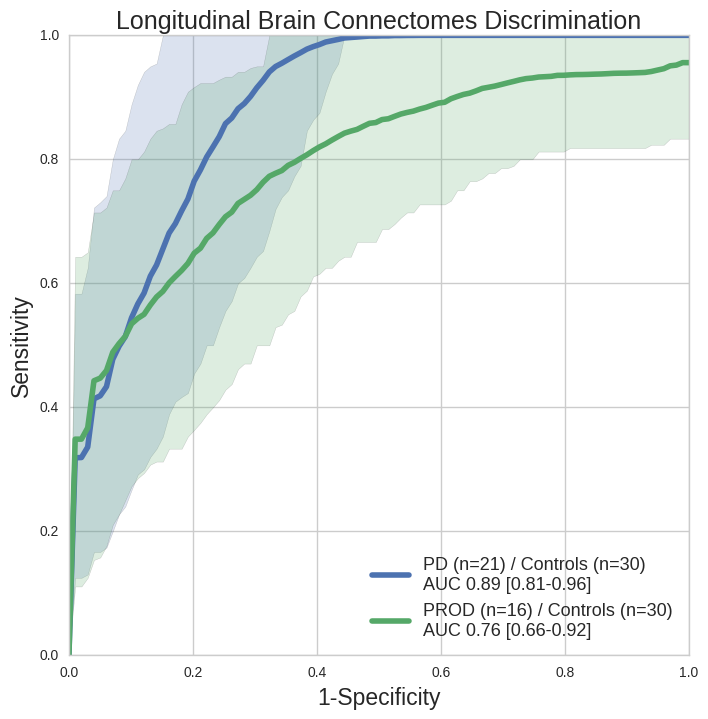

In [8]:
def rocInfo( scoresIn, yIn, lblIn, toInvert=False, printSig=False ):
    rocDic = {}
    pdArr = scoresIn[ yIn==1 ]
    cntArr = scoresIn[ yIn==0 ]
    (rocDic['aucConfDown'], rocDic['aucConfUp'], 
     rocDic['fprGridVec'], rocDic['tprGridMat'] ) = conn_utils.rocBootstrap( cntArr, pdArr)
    rocDic['leg'] = '{:}\nAUC {:} [{:0.2f}-{:0.2}]'.format( lblIn,
                                                            utilsStats.sigTestAUC( cntArr, pdArr, 'auc' ), 
                                                            rocDic['aucConfDown'], rocDic['aucConfUp'] )
    

    if printSig:
        print  utilsStats.sigTestAUC( cntArr, pdArr, 'long' )
    return rocDic

def formatROC():
    plt.legend( loc='lower right', prop={'size':13} ) 
    #aucTitleLbl = '\nAUC {:} [{:0.2f}-{:0.2}]' .format( utilsStats.sigTestAUC( cntFullScoresFr.nqScore.values ,pdFullScoresFr.nqScore.values ), aucConfDown, aucConfUp )
    plt.xlabel('1-Specificity' )
    plt.ylabel('Sensitivity')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.tick_params(axis="y", labelsize=10 )
    plt.tick_params(axis="x", labelsize=10 )

# plot roc
plt.figure( figsize=(8,8) ) 
lblsLst = (scoresFr['Group'] == 'PD') | (scoresFr['Group'] == 'Control')
roc0 = rocInfo( scoresFr[lblsLst]['scores'], scoresFr[lblsLst]['gt']>1, 'PD (n=21) / Controls (n=30)' )
conn_utils.plotRocAndConf( roc0['fprGridVec'], roc0['tprGridMat'], roc0['leg']  )

lblsLst = (scoresFr['Group'] == 'Prodromal') | (scoresFr['Group'] == 'Control')
roc1 = rocInfo( scoresFr[lblsLst]['scores'], scoresFr[lblsLst]['gt']==1, 'PROD (n=16) / Controls (n=30)' )
conn_utils.plotRocAndConf( roc1['fprGridVec'], roc1['tprGridMat'], roc1['leg'] )



formatROC()
plt.title('Longitudinal Brain Connectomes Discrimination')    
    

# Significant Connections

/home/lgianca/anaconda2/envs/maya/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide


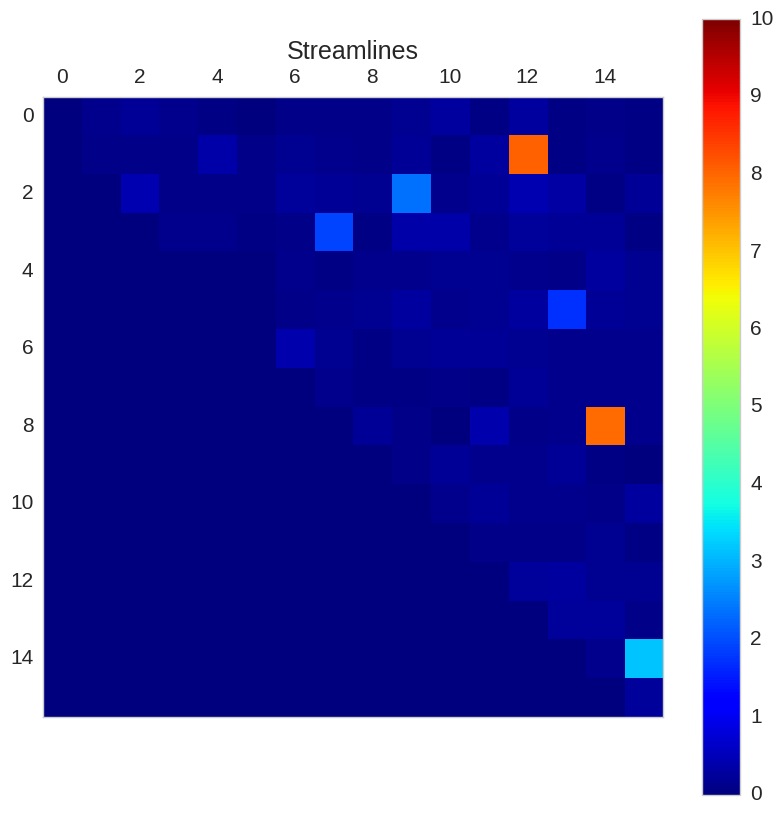

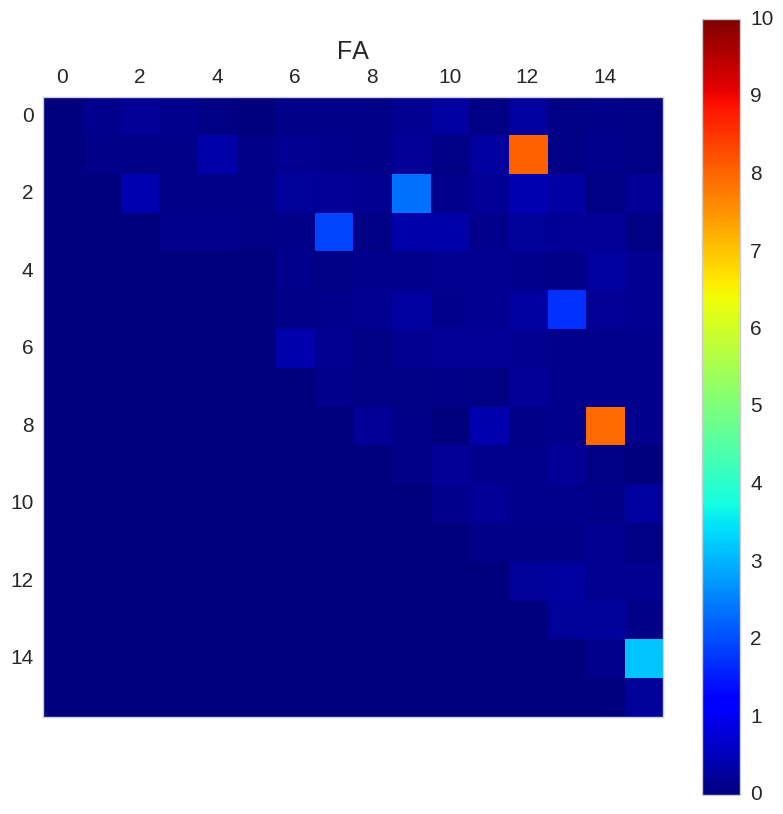

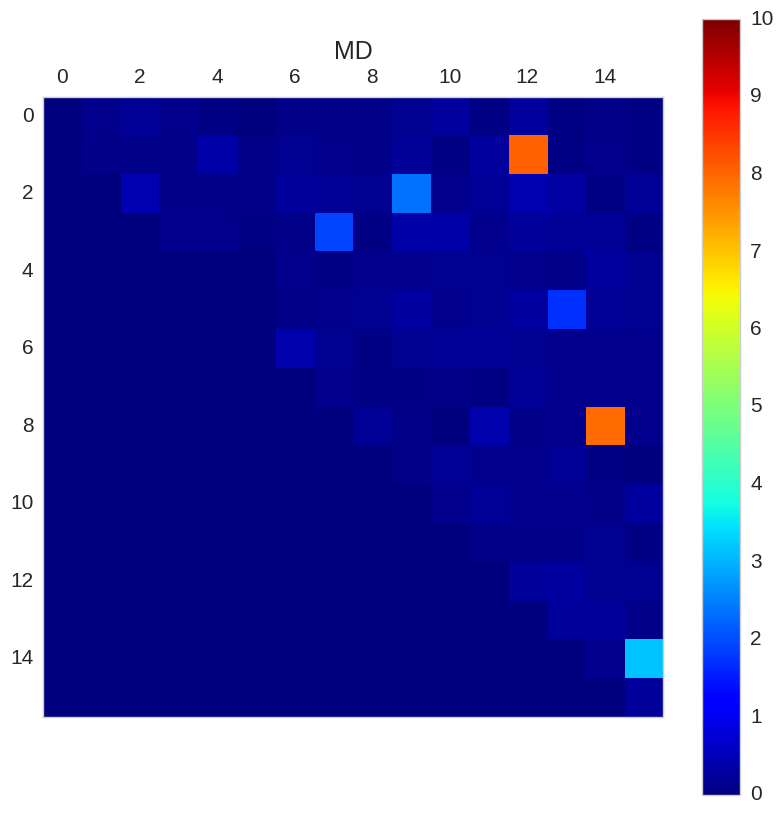

In [9]:
def genFullWeightMat( featWeightLst, op=np.average, conn='stream'  ):
    """
    Create matrix from list feat weight and run vector operation
    """
    # cnv to numpy
    featWeightArr  = np.array(featWeightLst)
    # run operation (np.average, np.std, etc. on absolute values)
    res = op(np.abs(featWeightArr), 0)
    # convert to matrix
    # first - split weights of the three connectomes:
    if conn is 'stream':
        res = res[:136] 
    elif conn is 'FA':
        res = res[136:-136]
    elif conn is 'MD':
        res = res[-136:]
    fullWeightMat = conn_utils.compVec2Conn(res)
    
    return fullWeightMat

def plotHeatMap(matIn, **matarg):
    plt.figure(figsize=(10,10))
    plt.matshow( matIn,fignum=False, **matarg )
    plt.set_cmap( 'jet' )
    plt.grid(False)
    plt.colorbar()




def computeStdDevMat( weightMat, rndWeightMat, connIn='stream' ):
    """
    Compute relevance matrix based on standard deviations from noise
    """
    # calculate full weight matrix
    # The number of weights is 21 * 408. Those 408 are devided by 136*3, for each connetome (structural, FA, MD). 
    fullWeightMat = genFullWeightMat(weightMat, np.average, connIn)
    # rnd weights distributions
    rndWeightAvgMat = genFullWeightMat(rndWeightMat, np.average, connIn)
    rndWeightStdMat = genFullWeightMat(rndWeightMat, np.std, connIn)

    # number of standard deviations from noise 
    fullWeightMatSN = np.abs(fullWeightMat - rndWeightAvgMat) / rndWeightStdMat
    # remove division by 0s
    fullWeightMatSN[~np.isfinite(fullWeightMatSN)] = 0
    
    return fullWeightMatSN


# calculate full weight matrix
# The number of weights is 21 * 408. Those 408 are devided by 136*3, for each connetome (structural, FA, MD). 
conn = 'stream'
weightSnStMat = computeStdDevMat( mdlDic[modelID]['featWeight'], mdlDic[modelID]['rndFeatWeights'], conn )
plotHeatMap(weightSnStMat, vmin=0, vmax=10 )
plt.title('Streamlines')
conn = 'FA'
weightSnFaMat = computeStdDevMat( mdlDic[modelID]['featWeight'], mdlDic[modelID]['rndFeatWeights'], conn )
plotHeatMap(weightSnStMat, vmin=0, vmax=10 )
plt.title('FA')
conn = 'MD'
weightSnMdMat = computeStdDevMat( mdlDic[modelID]['featWeight'], mdlDic[modelID]['rndFeatWeights'], conn )
plotHeatMap(weightSnStMat, vmin=0, vmax=10 )
plt.title('MD')



In [10]:

def printRelConn( weightSnIn, stdThIn ):
    # find relevant connections
    cLst, rLst = np.nonzero(weightSnIn>stdThIn)
    # weights and label generator
    weightsLst = []
    lblLst = []    
    for c,r in zip(cLst,rLst):
        lbl = connFr.area.iloc[c] + ' ' + connFr.area.iloc[r]
        lblLst.append(lbl)
        weightsLst.append(weightSnIn[c,r])
    # sort by weights
    sortedIds = np.argsort( -1 * np.array(weightsLst) )
    
    for sId in sortedIds:
        print lblLst[sId], '({:0.2f})'.format(weightsLst[sId])
        
# According to Chebyshev's inequality, 5 STD contains at least 96% of noise
stdTh = 5
print '='*40, '5 std as Threshold'

print '='*20, 'Streamlines'
printRelConn( weightSnStMat, stdTh ) 
print '='*20, 'FA'
printRelConn( weightSnFaMat, stdTh ) 
print '='*20, 'MD'
printRelConn( weightSnMdMat, stdTh ) 
print '='*40

stdTh = 1
print '\n\n', '='*40, '1 std as Threshold'

print '='*20, 'Streamlines'
printRelConn( weightSnStMat, stdTh ) 
print '='*20, 'FA'
printRelConn( weightSnFaMat, stdTh ) 
print '='*20, 'MD'
printRelConn( weightSnMdMat, stdTh ) 
print '='*40

======================================== 5 std as Threshold
==================== Streamlines
right-red-nucleus left-globus-pallidus-interna (8.08)
left-putamen left-thalamus (7.97)
==================== FA
left-globus-pallidus-externa right-globus-pallidus-externa (6.67)
left-putamen left-globus-pallidus-externa (6.66)
right-caudate right-thalamus (5.34)
==================== MD


======================================== 1 std as Threshold
==================== Streamlines
right-red-nucleus left-globus-pallidus-interna (8.08)
left-putamen left-thalamus (7.97)
left-thalamus right-thalamus (3.19)
left-substantia-nigra right-putamen (2.37)
right-substantia-nigra right-caudate (1.93)
right-subthalamic-nucleus right-globus-pallidus-interna (1.75)
==================== FA
left-globus-pallidus-externa right-globus-pallidus-externa (6.67)
left-putamen left-globus-pallidus-externa (6.66)
right-caudate right-thalamus (5.34)
left-putamen right-putamen (2.82)
right-red-nucleus left-putamen (1.90)
righ

# Alternative method to compute significant connections

In [11]:
def getHUBs(connMatIn, connFrIn):
    """
    Generate weights HUBs for each brain area
    """
    # find HUbs
    globWgtArr = []
    for idxArea, areaName in zip(range(connMatIn.shape[0]), connFrIn['area'].values):
        val = np.sum(connMatIn[idxArea,:]) + np.sum(connMatIn[:,idxArea]);
        globWgtArr.append( {'area': areaName, 'val': val} )
    globWgtFr = pd.DataFrame( globWgtArr )

    # show 
    globWgtFr = globWgtFr.sort_values( 'val', ascending=False )
    
    return globWgtFr

def relevantAreasPVal( featWeightArr, rndFeatWeightArr, pvalTh =0.05, conn='stream'  ):
    weightsRndAbsArr = np.abs(np.array(featWeightArr))
    rndsamplingNum = float(weightsRndAbsArr.shape[0])

    # calculate percentage of time weight are above the median
    weightAbsVec = np.median(np.abs(np.array( rndFeatWeightArr )),0)
    subWeight = (np.sum(((weightAbsVec - weightsRndAbsArr) > 0), axis=0 )+1) / rndsamplingNum

    # threshold
    arrPvalTh = subWeight < pvalTh

    #format as matrix
    # first - split weights of the three connectomes:
    if conn is 'stream':
        arrPvalTh = arrPvalTh[:136] 
    elif conn is 'FA':
        arrPvalTh = arrPvalTh[136:-136]
    elif conn is 'MD':
        arrPvalTh = arrPvalTh[-136:]
    relWeightPvalMat = conn_utils.compVec2Conn(arrPvalTh)

    # return pValues
    pValArr = np.ones( subWeight.shape )
    pValArr[subWeight < pvalTh] = subWeight[subWeight < pvalTh]
    if conn is 'stream':
        pValArr = pValArr[:136] 
    elif conn is 'FA':
        pValArr = pValArr[136:-136]
    elif conn is 'MD':
        pValArr = pValArr[-136:]
    
    
    return relWeightPvalMat, pValArr

pvalTh = 0.001
relwMat, pValArr = relevantAreasPVal( mdlDic[modelID]['rndFeatWeights'], mdlDic[modelID]['featWeight'], pvalTh, conn )
# plot new 
# interactiveConnMat(relwMat, connFr['area'].values)
# print names
areasHUBs = getHUBs(relwMat, connFr) # times areas was selected


In [12]:
conn = 'stream'
relwMat, pValArr = relevantAreasPVal( mdlDic[modelID]['rndFeatWeights'], mdlDic[modelID]['featWeight'], pvalTh, conn )
relStFr = getHUBs(relwMat, connFr)

conn = 'FA'
relwMat, pValArr = relevantAreasPVal( mdlDic[modelID]['rndFeatWeights'], mdlDic[modelID]['featWeight'], pvalTh, conn )
relFaFr = getHUBs(relwMat, connFr)

conn = 'MD'
relwMat, pValArr = relevantAreasPVal( mdlDic[modelID]['rndFeatWeights'], mdlDic[modelID]['featWeight'], pvalTh, conn )
relMdFr = getHUBs(relwMat, connFr)

In [13]:
relStFr

,area,val
0,left-red-nucleus,17.0
4,left-subthalamic-nucleus,17.0
6,left-caudate,17.0
10,left-globus-pallidus-externa,17.0
11,right-globus-pallidus-externa,17.0
1,right-red-nucleus,16.0
2,left-substantia-nigra,16.0
3,right-substantia-nigra,16.0
5,right-subthalamic-nucleus,16.0
7,right-caudate,16.0


In [14]:
relFaFr

,area,val
0,left-red-nucleus,17.0
5,right-subthalamic-nucleus,17.0
6,left-caudate,17.0
12,left-globus-pallidus-interna,17.0
13,right-globus-pallidus-interna,17.0
14,left-thalamus,17.0
3,right-substantia-nigra,16.0
7,right-caudate,16.0
9,right-putamen,16.0
11,right-globus-pallidus-externa,16.0


In [15]:
relMdFr

,area,val
0,left-red-nucleus,17.0
3,right-substantia-nigra,17.0
6,left-caudate,17.0
8,left-putamen,17.0
9,right-putamen,17.0
12,left-globus-pallidus-interna,17.0
1,right-red-nucleus,16.0
2,left-substantia-nigra,16.0
4,left-subthalamic-nucleus,16.0
7,right-caudate,16.0


# Read UPDRS TESTS
- UPDRS MOTOR III
- UPDRS NON-MOTOR 

In [16]:
BASE_DIR = CONF['DIR_PPMI_CLIN_INFO']

# MOTOR UPDRS III / Hoen and Yahr
subjMotorFr = pd.read_csv( BASE_DIR + 'motor/MDS_UPDRS_Part_III__Post_Dose_.csv' )
subjMotorFr['date']= pd.to_datetime(subjMotorFr.INFODT)
# compute
subjFr2 = subjMotorFr[ ['PATNO','EVENT_ID', 'PAG_NAME', 'INFODT', 'NHY']].copy()
subjFr2['UPDRS-III'] = subjMotorFr.loc[:,'NP3SPCH':'NP3RTCON'].sum(axis=1).copy()
subjFr2['date']= pd.to_datetime(subjFr2.INFODT)

# MOCA 
subjMocaFr = pd.read_csv( BASE_DIR + 'non-motor/Montreal_Cognitive_Assessment__MoCA_.csv' )
subjMocaFr['date'] = pd.to_datetime(subjMocaFr.INFODT)

# subjFr2 = subjFr2.merge( subjMocaFr[['PATNO','EVENT_ID', 'MCATOT']], how='left',on=['PATNO','EVENT_ID'] )
# Symbol digit
subjDigitFr = pd.read_csv( BASE_DIR + 'non-motor/Symbol_Digit_Modalities.csv')
subjDigitFr['date'] = pd.to_datetime(subjDigitFr.INFODT)
# subjDigitFr['SDMTOTAL']
#Hopkins Verbal Learning Test (delayed recall HVLTDRTM)
subjHopFr = pd.read_csv( BASE_DIR + 'non-motor/Hopkins_Verbal_Learning_Test.csv')
subjHopFr['date'] = pd.to_datetime(subjHopFr.INFODT)


# UPSIT (Smell test, TOTAL_CORRECT)

subjUpsitFr =  pd.read_csv( BASE_DIR + 'non-motor/Olfactory_UPSIT.csv' )
subjUpsitFr['date'] = pd.to_datetime(subjUpsitFr['COMPLT_DATE'])
subjUpsitFr['PATNO'] = subjUpsitFr['SUBJECT_ID']

# Match scores with Clinical Tests

In [17]:
# BL is in imgInfoFr2 visit 1
# V0X is in imgInfoFr2 visit X+1
for pID in imgInfoFr2full.index.values:
    #all additional scales about the patient
    auxInfoFr = subjFr2[subjFr2['PATNO'] == pID]
    
    #-- Identify the relevant start and end event according to the imaging data info (in imgInfoFr2full)
    relEventStart = ''
    relEventEnd = ''
    if (imgInfoFr2full['Visit'].loc[pID] == 1) or (imgInfoFr2full['Visit'].loc[pID] == 0):
        relEventStart = 'BL'
        if pID in (60073, 60024):
            relEventStart = 'SC'
    elif (imgInfoFr2full['Visit'].loc[pID] == 5):
        relEventStart = 'V04'
    else:
        print pID, '  not BL!!!'

    idList = ['V' + str(0) + str(int(imgInfoFr2full['Visit_lst'].loc[pID]-1))]
    if not auxInfoFr[auxInfoFr['EVENT_ID']==idList[0]].size == 0:
        relEventEnd = idList[0]
    elif pID == 85236:
        relEventEnd = 'V04'
    elif pID == 3181:
        relEventEnd = 'V05'
    elif pID == 3102:
        relEventEnd = 'ST'
    else:
        print pID, '  not match last!!!'
    #--
        

    # start events
    imgInfoFr2full.loc[pID,'UPDRS'] = auxInfoFr[auxInfoFr['EVENT_ID']==relEventStart]['UPDRS-III'].values[0]
    imgInfoFr2full.loc[pID,'NHY'] = auxInfoFr[auxInfoFr['EVENT_ID']==relEventStart]['NHY'].values[0]
#     imgInfoFr2full.loc[pID,'MCATOT'] = auxInfoFr[auxInfoFr['EVENT_ID']==relEventStart]['MCATOT'].values[0]
    
    
    # end events
    imgInfoFr2full.loc[pID,'UPDRS_lst'] = auxInfoFr[auxInfoFr['EVENT_ID']==relEventEnd]['UPDRS-III'].values[0]
    imgInfoFr2full.loc[pID,'NHY_lst'] = auxInfoFr[auxInfoFr['EVENT_ID']==relEventEnd]['NHY'].values[0] 
#     imgInfoFr2full.loc[pID,'MCATOT_lst'] = auxInfoFr[auxInfoFr['EVENT_ID']==relEventEnd]['MCATOT'].values[0]

In [18]:
def findClosestDate(dateRef, haystackFr, pIDin):
    """
    Find closest row in haystack (with PATNO and date columns) according to patient ID and dateRef
    """
    if(np.sum(haystackFr['PATNO'] == pIDin)==0):
        print(pIDin,'not found')
        return None
    
    closestIdx = (dateRef-(haystackFr[haystackFr['PATNO'] == pIDin]['date'])).abs().sort_values().index[0]
    
    return haystackFr.loc[closestIdx]


# get UPDRS in the OFF state only
subjFr2off = subjFr2[subjFr2.PAG_NAME == 'NUPDRS3']
# BL is in imgInfoFr2 visit 1
# V0X is in imgInfoFr2 visit X+1
for pID in imgInfoFr2full.index.values: 
    # Moca
    imgInfoFr2full.loc[pID,'MOCA'] = \
            findClosestDate( imgInfoFr2full.loc[pID, 'adate'], subjMocaFr, pID )['MCATOT']
    imgInfoFr2full.loc[pID,'MOCA_lst'] = \
            findClosestDate( imgInfoFr2full.loc[pID, 'adate_lst'], subjMocaFr, pID )['MCATOT']
    # SymbolDigittest
    imgInfoFr2full.loc[pID,'SDM'] = \
            findClosestDate( imgInfoFr2full.loc[pID, 'adate'], subjDigitFr, pID )['SDMTOTAL']
    imgInfoFr2full.loc[pID,'SDM_lst'] = \
            findClosestDate( imgInfoFr2full.loc[pID, 'adate_lst'], subjDigitFr, pID )['SDMTOTAL']
    
    

In [19]:
imgInfoFr2full['UPDRS-diff'] = imgInfoFr2full['UPDRS_lst'] - imgInfoFr2full['UPDRS']
imgInfoFr2full['NHY-diff'] = imgInfoFr2full['NHY_lst'] - imgInfoFr2full['NHY']
imgInfoFr2full['MOCA-diff'] = imgInfoFr2full['MOCA_lst'] - imgInfoFr2full['MOCA']
imgInfoFr2full['SDM-diff'] = imgInfoFr2full['SDM_lst'] - imgInfoFr2full['SDM']

In [20]:
imgInfoFr3full = imgInfoFr2full.join( scoresFr.set_index('pID')[['scores']])
imgInfoFr3full['Female'] = (imgInfoFr3full['Sex'] == 'F')*1
imgInfoFr3full.Group.unique()

array(['Prodromal', 'PD', 'Control'], dtype=object)

# Statistical Analysis

PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 0.89 (***p<0.001), CNT: med 0.14 spread 0.24; PD: med 0.61 spread 0.44
CNT vs. Prodr 0.76 (**p<0.01), CNT: med 0.14 spread 0.24; Prodr: med 0.51 spread 0.64
info for power analysis
PD n=21, Prodromal n=16, Control n=30, analisys type: power
CNT vs. PD 0.89 (***p<0.001), CNT: med 0.22 spread 0.22; PD: med 0.63 spread 0.26
CNT vs. Prodr 0.76 (**p<0.01), CNT: med 0.22 spread 0.22; Prodr: med 0.53 spread 0.35
CNT vs. PD total STD 0.31114
CNT vs. Prodromal total STD 0.31141
cutoff point PD/CNT
('cut off point', 0.32936704602592887)
('sens', 0.90476190476190477)
('spec', 0.76666666666666661)
('acc', 0.82352941176470584)
cutoff point RBD/CNT
('cut off point', 0.3832966057337398)
('sens', 0.6875)
('spec', 0.80000000000000004)
('acc', 0.76086956521739135)


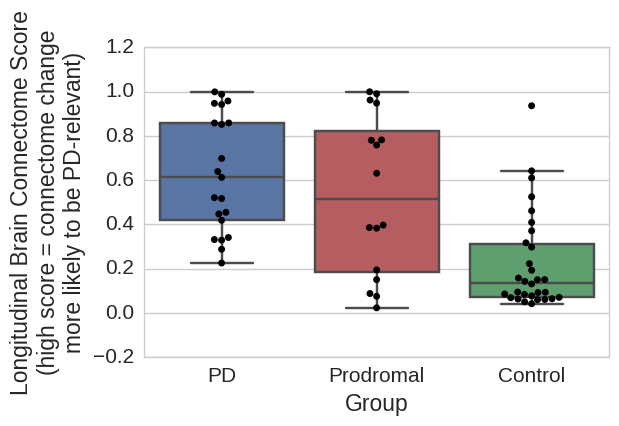

In [30]:
def printDiffStats( dataFr, lblGroup, lblScore, typeIn='median' ):
    """
    typeIn=median|power
    """

    groupPdFr = dataFr[dataFr[lblGroup] == 'PD'][ lblScore ]
    groupProdrFr = dataFr[dataFr[lblGroup] == 'Prodromal'][ lblScore ]
    groupCntFr = dataFr[dataFr[lblGroup] == 'Control'][ lblScore ]
    
    def iqr(arrIn):
        """
        interquantile range
        """
        return (np.percentile( arrIn, 75)-np.percentile( arrIn, 25))
    
    avgF = np.mean
    spreadF = np.std
    if typeIn =='median':
        avgF=np.median
        spreadF=iqr
    
    print ('PD n={:}, Prodromal n={:}, Control n={:}, analisys type: {:}'.format(len(groupPdFr),len(groupProdrFr),len(groupCntFr), typeIn))
    print ('CNT vs. PD {:}, CNT: med {:0.2f} spread {:0.2f}; PD: med {:0.2f} spread {:0.2f}' \
                                .format( utilsStats.sigTestAUC( groupCntFr.values, groupPdFr.values ), 
                                            avgF(groupCntFr.values), spreadF(groupCntFr.values),
                                            avgF(groupPdFr.values), spreadF(groupPdFr.values) ))
    print ('CNT vs. Prodr {:}, CNT: med {:0.2f} spread {:0.2f}; Prodr: med {:0.2f} spread {:0.2f}' \
                                .format( utilsStats.sigTestAUC( groupCntFr.values, groupProdrFr.values ), 
                                            avgF(groupCntFr.values), spreadF(groupCntFr.values),
                                            avgF(groupProdrFr.values), spreadF(groupProdrFr.values) ))
    
    # compute power
    if typeIn=='power':
        print ('CNT vs. PD total STD {:0.5f}').format( \
                                (groupCntFr.append(groupPdFr)).std())
        print ('CNT vs. Prodromal total STD {:0.5f}').format( \
                                (groupCntFr.append(groupProdrFr)).std())

def logRegrCorrected( dataFr, lblGroup, lblScore, nameGroupLst=['Control','PD'], confounderLst=['daysDiff','Age','Female'] ):
    #select
    group1Fr = dataFr[dataFr[lblGroup] == nameGroupLst[0]][ np.append(confounderLst,lblScore) ].copy()
    group1Fr['y'] = 0
    group2Fr = dataFr[dataFr[lblGroup] == nameGroupLst[1]][ np.append(confounderLst,lblScore) ].copy()
    group2Fr['y'] = 1
    # join
    groupAllFr = group1Fr.append(group2Fr).copy()
    # add intercept
    groupAllFr['intercept'] = 1.0
    
    # compute corrected logistic regression
    covars = np.append(lblScore,confounderLst)
    covars = np.append(covars,'intercept')
    logit = sm.Logit(groupAllFr['y'], groupAllFr[covars])

    # fit the model
    result = logit.fit()
    
    print(result.summary())
    
    
# get palette
currPal = sns.palettes.get_color_cycle()

# set color per group
palGrp = {"PD": currPal[0], "Control": currPal[1], "Prodromal": currPal[2]}
# set ordering
orderingLst=['PD', 'Prodromal', 'Control']

# set group names
scoresFr['Group'] = 'Control'
scoresFr.loc[scoresFr['gt'] == 1, 'Group'] = 'Prodromal'
scoresFr.loc[scoresFr['gt'] == 2, 'Group'] = 'PD'

# join everything for statistical correction 
scoresColumns = list(scoresFr.columns[scoresFr.columns.str.startswith('scores')])
imgInfoFr3full = imgInfoFr2full.join( scoresFr.set_index('pID')[scoresColumns])
imgInfoFr3full['Female'] = (imgInfoFr3full['Sex'] == 'F')*1

sns.boxplot( x='Group', y='scores', data=scoresFr, fliersize=0,order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y='scores', data=scoresFr, color='black',order=orderingLst )
plt.ylabel('Longitudinal Brain Connectome Score\n(high score = connectome change\nmore likely to be PD-relevant)')

printDiffStats( scoresFr, 'Group', 'scores' )
print ('='*30)
print('info for power analysis')
print ('='*30)

printDiffStats( scoresFr, 'Group', 'scores', typeIn='power' )
print ('='*30)

#---- find cutoff point PD/CNT
acc,sens,spec,roc_auc, cutoffTh, confusionMat, kappa = \
    utilsStats.findCutoffPnt3( scoresFr[scoresFr['Group'] == 'PD'][ 'scores' ], scoresFr[scoresFr['Group'] == 'Control'][ 'scores' ]  )

print ('='*30)
print('cutoff point PD/CNT')
print ('='*30)
    
print ( 'cut off point', cutoffTh  )
print ( 'sens', sens  )
print ( 'spec', spec  )
print ( 'acc', acc  )
#----

#---- find cutoff point RBD/CNT
acc,sens,spec,roc_auc, cutoffTh, confusionMat, kappa = \
    utilsStats.findCutoffPnt3( scoresFr[scoresFr['Group'] == 'Prodromal'][ 'scores' ], scoresFr[scoresFr['Group'] == 'Control'][ 'scores' ]  )

print ('='*30)
print('cutoff point RBD/CNT')
print ('='*30)
    
print ( 'cut off point', cutoffTh  )
print ( 'sens', sens  )
print ( 'spec', spec  )
print ( 'acc', acc  )
#----
    
# # correct for confounders  with logistic regression
# logRegrCorrected( imgInfoFr3full, 'Group', 'scores', ['Control','PD'], ['Age','Female'] )
# logRegrCorrected( imgInfoFr3full, 'Group', 'scores', ['Control','Prodromal'], ['Age','Female'] )

In [31]:
# correct for confounders  with logistic regression for all classifiers

scoresColumns = list(scoresFr.columns[scoresFr.columns.str.startswith('scores')])

for scoreCol in scoresColumns:
    if scoreCol == 'scores':
        continue
    print '='*40
    print '='*40, 'Statistical analysis for ML classifier "', scoreCol, '"'
    logRegrCorrected( imgInfoFr3full, 'Group', scoreCol, ['Control','PD'], ['Age','Female'] )
    logRegrCorrected( imgInfoFr3full, 'Group', scoreCol, ['Control','Prodromal'], ['Age','Female'] )

======================================== Statistical analysis for ML classifier " scores-Logistic Regression (L1 reg.) "
Optimization terminated successfully.
         Current function value: 0.398325
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.4121
Time:                        15:29:22   Log-Likelihood:                -20.315
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                 2.886e-06
                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   46
Model:                          Logit   Df Residuals:                       42
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.1615
Time:                        15:29:22   Log-Likelihood:                -24.921
converged:                       True   LL-Null:                       -29.720
                                        LLR p-value:                   0.02232
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
scores-Random Forest Classifier     7.1428      3.469      2.059      0.040       0.343      13.942
Age                                 0.1042      0.074      1.414    

PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 1.00 (***p<0.001), CNT: med 0.00 spread 0.00; PD: med 2.00 spread 1.00
CNT vs. Prodr 0.53 (not sig. p=0.19), CNT: med 0.00 spread 0.00; Prodr: med 0.00 spread 0.00
PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 1.00 (***p<0.001), CNT: med 0.00 spread 0.00; PD: med 2.00 spread 1.00
CNT vs. Prodr 0.58 (not sig. p=0.07), CNT: med 0.00 spread 0.00; Prodr: med 0.00 spread 0.00


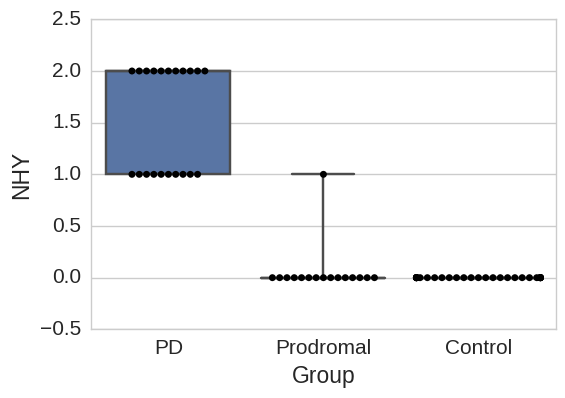

In [32]:
lbl = 'NHY'
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('NHY')

printDiffStats( imgInfoFr2full, 'Group', lbl )
printDiffStats( imgInfoFr2full, 'Group', lbl + '_lst')
# # correct for confounders  with logistic regression
# logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
# logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )

PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 0.60 (not sig. p=0.05), CNT: med 0.00 spread 0.00; PD: med 0.00 spread 1.00
CNT vs. Prodr 0.55 (not sig. p=0.32), CNT: med 0.00 spread 0.00; Prodr: med 0.00 spread 0.00
Optimization terminated successfully.
         Current function value: 0.587038
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.1335
Time:                        15:29:23   Log-Likelihood:                -29.939
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                   0.02643
                 coef    

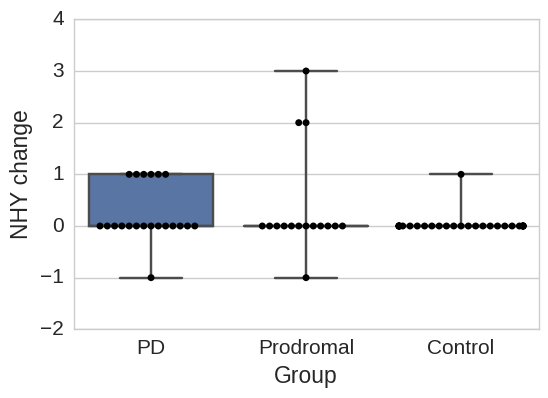

In [33]:
lbl = 'NHY-diff'
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('NHY change')

printDiffStats( imgInfoFr2full, 'Group', lbl )

# correct for confounders  with logistic regression
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )

PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 1.00 (***p<0.001), CNT: med 0.00 spread 1.75; PD: med 22.00 spread 9.00
CNT vs. Prodr 0.70 (*p<0.05), CNT: med 0.00 spread 1.75; Prodr: med 1.50 spread 4.25
Optimization terminated successfully.
         Current function value: 0.077089
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.8862
Time:                        15:29:23   Log-Likelihood:                -3.9316
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                 3.192e-13
                 coef    std err    

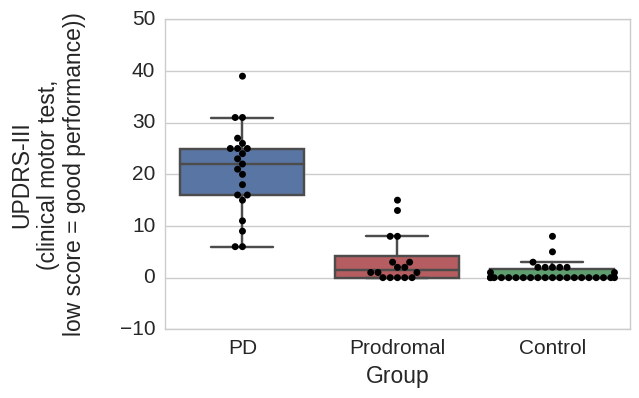

In [34]:
lbl = 'UPDRS'
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('UPDRS-III\n(clinical motor test,\nlow score = good performance))\n')

printDiffStats( imgInfoFr2full, 'Group', lbl )
# correct for confounders  with logistic regression
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )
# last visit
print('='*30,'last visit')
printDiffStats( imgInfoFr2full, 'Group', lbl + '_lst')
logRegrCorrected( imgInfoFr3full, 'Group', lbl+ '_lst', ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl+ '_lst', ['Control','Prodromal'], ['Age','Female'] )




PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 0.70 (*p<0.05), CNT: med 0.00 spread 1.00; PD: med 2.00 spread 7.00
CNT vs. Prodr 0.60 (not sig. p=0.24), CNT: med 0.00 spread 1.00; Prodr: med 0.50 spread 4.25
Optimization terminated successfully.
         Current function value: 0.593964
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.1233
Time:                        15:29:24   Log-Likelihood:                -30.292
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                   0.03640
                 coef    std err 

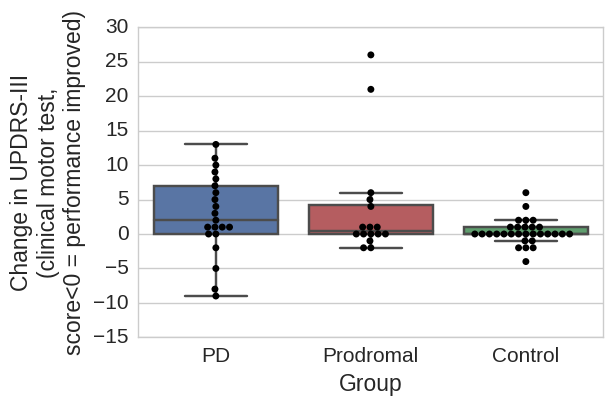

In [35]:
lbl = 'UPDRS-diff'
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('Change in UPDRS-III\n(clinical motor test,\nscore<0 = performance improved)')

printDiffStats( imgInfoFr2full, 'Group', lbl )
# correct for confounders  with logistic regression
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )

PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 0.35 (not sig. p=0.07), CNT: med 43.00 spread 7.75; PD: med 38.00 spread 11.00
CNT vs. Prodr 0.21 (**p<0.01), CNT: med 43.00 spread 7.75; Prodr: med 32.50 spread 10.50
Optimization terminated successfully.
         Current function value: 0.609029
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.1011
Time:                        15:29:24   Log-Likelihood:                -31.060
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                   0.07243
                 coef    s

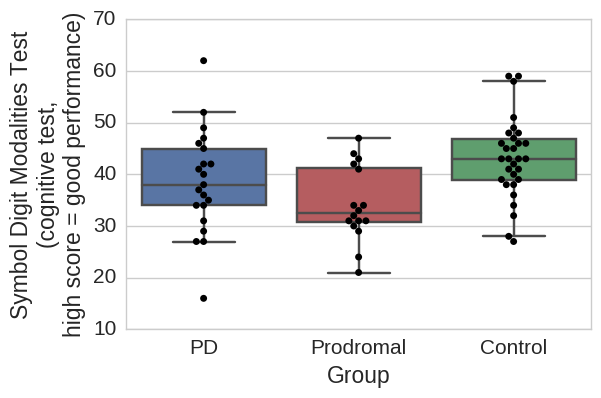

In [36]:
lbl = 'SDM'
plt.figure()
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('Symbol Digit Modalities Test\n(cognitive test,\nhigh score = good performance)')
printDiffStats( imgInfoFr2full, 'Group', lbl )
# correct for confounders  with logistic regression
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )

# last visit
print('='*30,'last visit')
printDiffStats( imgInfoFr2full, 'Group', lbl + '_lst')
logRegrCorrected( imgInfoFr3full, 'Group', lbl+ '_lst', ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl+ '_lst', ['Control','Prodromal'], ['Age','Female'] )



PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 0.40 (not sig. p=0.21), CNT: med 0.00 spread 8.25; PD: med -3.00 spread 5.00
CNT vs. Prodr 0.56 (not sig. p=0.55), CNT: med 0.00 spread 8.25; Prodr: med 0.00 spread 4.50
Optimization terminated successfully.
         Current function value: 0.605592
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.1061
Time:                        15:29:25   Log-Likelihood:                -30.885
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                   0.06198
                 coef   

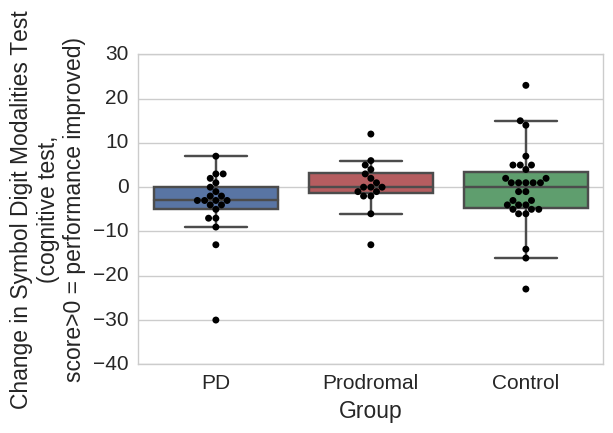

In [37]:
lbl = 'SDM-diff'
plt.figure()
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('Change in Symbol Digit Modalities Test\n(cognitive test,\nscore>0 = performance improved)')

printDiffStats( imgInfoFr2full, 'Group', lbl )
# correct for confounders  with logistic regression
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )

PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 0.28 (**p<0.01), CNT: med 28.00 spread 1.75; PD: med 27.00 spread 3.00
CNT vs. Prodr 0.38 (not sig. p=0.17), CNT: med 28.00 spread 1.75; Prodr: med 27.00 spread 1.50
Optimization terminated successfully.
         Current function value: 0.500370
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                  0.2614
Time:                        15:29:25   Log-Likelihood:                -25.519
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                 0.0004261
                 coef    std

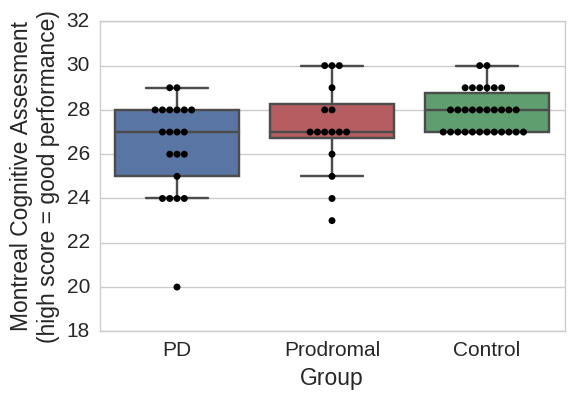

In [38]:
lbl = 'MOCA'
plt.figure()
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('Montreal Cognitive Assesment\n(high score = good performance)')
printDiffStats( imgInfoFr2full, 'Group', lbl )
# correct for confounders  with logistic regression
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )

# last visit
print('='*30,'last visit')
printDiffStats( imgInfoFr2full, 'Group', lbl + '_lst')
logRegrCorrected( imgInfoFr3full, 'Group', lbl+ '_lst', ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl+ '_lst', ['Control','Prodromal'], ['Age','Female'] )


PD n=21, Prodromal n=16, Control n=30, analisys type: median
CNT vs. PD 0.60 (not sig. p=0.25), CNT: med -1.00 spread 3.00; PD: med 0.00 spread 4.00
CNT vs. Prodr 0.56 (not sig. p=0.55), CNT: med -1.00 spread 3.00; Prodr: med -0.50 spread 4.25
Optimization terminated successfully.
         Current function value: 0.624938
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   51
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Nov 2018   Pseudo R-squ.:                 0.07757
Time:                        15:29:26   Log-Likelihood:                -31.872
converged:                       True   LL-Null:                       -34.552
                                        LLR p-value:                    0.1472
                 coef 

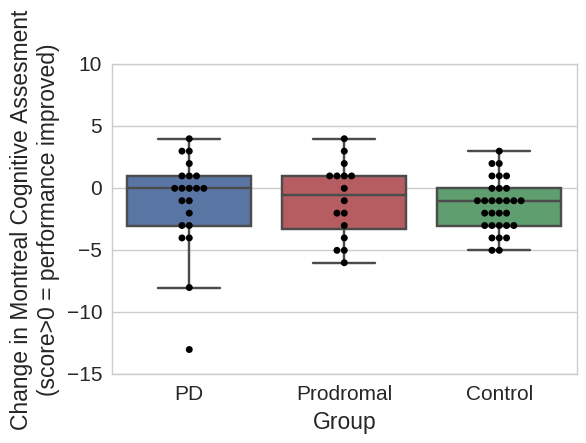

In [39]:
lbl = 'MOCA-diff'
plt.figure()
sns.boxplot( x='Group', y=lbl, data=imgInfoFr2full, fliersize=0, order=orderingLst, palette=palGrp )
sns.swarmplot( x='Group', y=lbl, data=imgInfoFr2full, color='black', order=orderingLst )
plt.ylabel('Change in Montreal Cognitive Assesment\n(score>0 = performance improved)')
printDiffStats( imgInfoFr2full, 'Group', lbl )
# correct for confounders  with logistic regression
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','PD'], ['Age','Female'] )
logRegrCorrected( imgInfoFr3full, 'Group', lbl, ['Control','Prodromal'], ['Age','Female'] )

# Subgrouping

In [40]:
# ORDER clinical tests

subjFr3 = subjFr2.copy()

# select only test in the OFF state 'NUPDRS3'
subjFr3 = subjFr3[subjFr3.PAG_NAME == 'NUPDRS3']
# subjFr3['date']= pd.to_datetime(subjFr3.INFODT)

subjFr3.sort_values(['PATNO', 'date'], inplace=True)


subjMocaFr2 = subjMocaFr.sort_values(['PATNO', 'date'], inplace=False)
subjDigitFr2 = subjDigitFr.sort_values(['PATNO', 'date'], inplace=False)


#-- Set Threshold
thScores = 0.35

scoresProdrFr = scoresFr[scoresFr.Group == 'Prodromal']

prodrUpThArr = scoresProdrFr[scoresProdrFr.scores >= thScores]['pID']
prodrLoThArr = scoresProdrFr[scoresProdrFr.scores < thScores]['pID']
#--

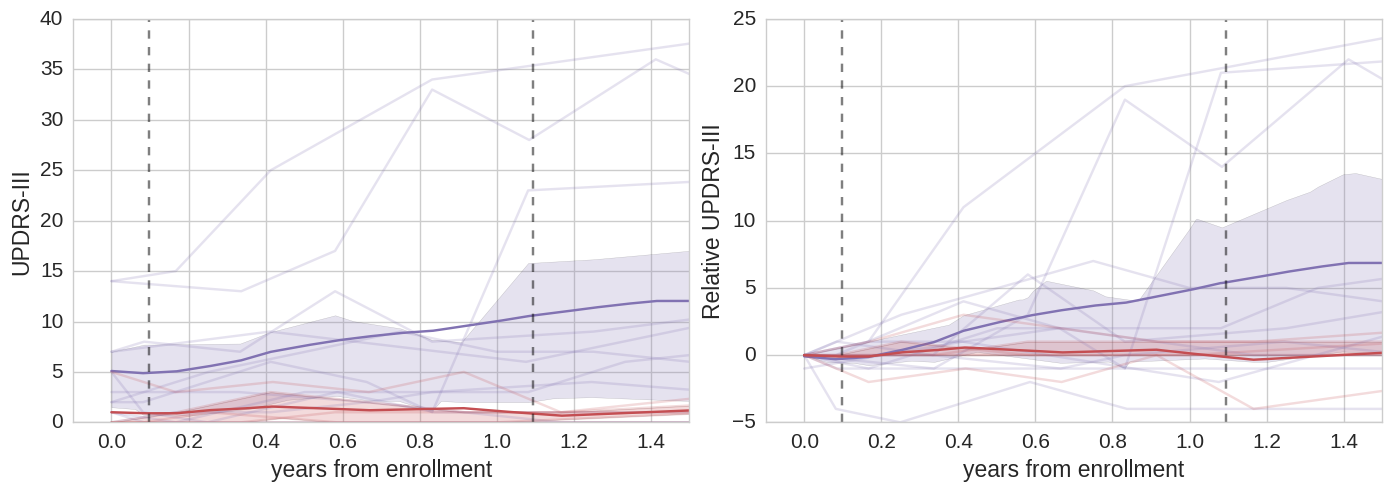

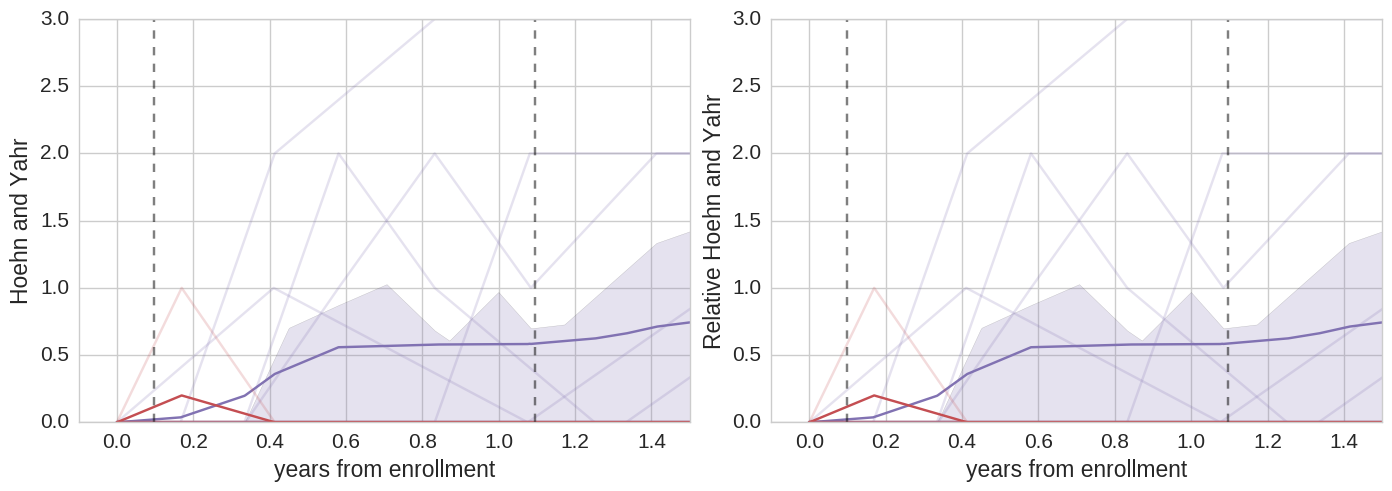

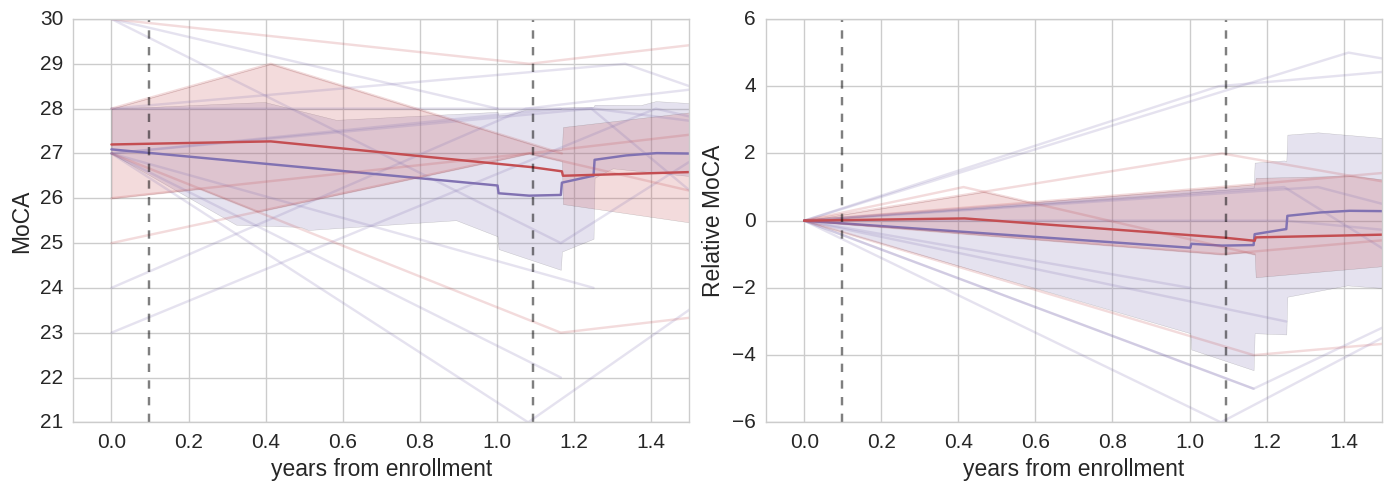

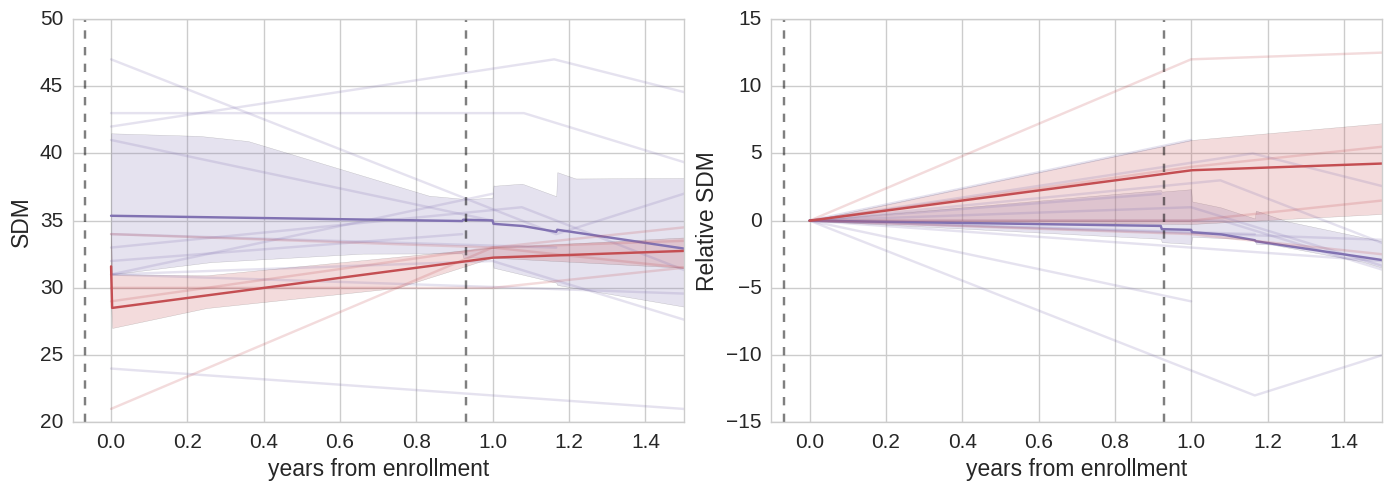

In [41]:
def plotAgr(grpInLst, grpInFr=subjFr3, cIn='b', metLbl = 'UPDRS-III', maxDaysLbl= '800 days', \
            isRelative=False, dateImgFr=None):
    """
    dateImgFr: imaging sessions dates. Must contain 'adate_lst','adate' and pID as index
    """
    global progMetAllNoIntFr
    
    #init
    progMetAllFr = pd.DataFrame()
    progMetAllNoIntFr = pd.DataFrame()
    # lists of time offsets of imaging date from baseline
    # (used only if dateImgFr is set)
    imgDateStOffsetLst = []
    imgDateEndOffsetLst = []
    for pID in grpInLst:
        # get progression of the metric
        progMetFr = grpInFr[grpInFr['PATNO']==pID][[metLbl,'date']]

        # absolute measurement
        progMetFr['measurement'] = progMetFr[metLbl]
        # Compute relative measurements if necessary
        if isRelative:
            progMetFr['measurement'] = progMetFr[metLbl]-progMetFr[metLbl].iloc[0]
        
        # set starting date as 0 
        startDate = progMetFr['date'].iloc[0]
        progMetFr['daysDiff'] = progMetFr['date'] - startDate
        progMetFr = progMetFr.groupby('daysDiff').mean() # avoid double daysDiff
        # add Patient ID to dataframe
        progMetFr['pID'] = int(pID)

        # data imputation
        progMetNoIntFr = progMetFr.copy()
#         progMetFr = progMetFr.resample('D').bfill()
        progMetFr = progMetFr.resample('D').interpolate()
    
    
    
        
        if dateImgFr is not None:
            imgDateStOffsetLst.append( (dateImgFr.loc[pID]['adate']- startDate)/ np.timedelta64(1,'Y').astype('timedelta64[ns]') )
            imgDateEndOffsetLst.append( (dateImgFr.loc[pID]['adate_lst']- startDate)/ np.timedelta64(1,'Y').astype('timedelta64[ns]') )
        
        
        # append
        progMetAllFr = progMetAllFr.append(progMetFr)
        progMetAllNoIntFr = progMetAllNoIntFr.append(progMetNoIntFr)

    def upQuantile(arrIn):
        return np.percentile(arrIn, 75)

    def lowQuantile(arrIn):
        return np.percentile(arrIn, 25)
    
    def smplCount(arrIn):
        return len(arrIn)
    
    
    # compute statistics
    grpFr = progMetAllFr['measurement'].reset_index().groupby('daysDiff').aggregate([np.mean, upQuantile , lowQuantile, smplCount, np.std])
    # trim and duplicate
    grpFr = grpFr[:maxDaysLbl].copy()
    # trim progMetAllNoIntFr
    progMetAllNoIntFr = progMetAllNoIntFr[progMetAllNoIntFr.index < maxDaysLbl].copy()

    # time domain
    domainX = grpFr.index.values / np.timedelta64(1,'Y').astype('timedelta64[ns]')
    # plot
    plt.fill_between( domainX, grpFr['measurement']['lowQuantile'], grpFr['measurement']['upQuantile'], facecolor=cIn, alpha=0.2 )
    plt.plot( domainX, grpFr['measurement']['mean'], c=cIn )
    
    # plot single lines
    for pID in grpInLst: 
        tmpFr = progMetAllNoIntFr[progMetAllNoIntFr.pID == pID]
        domainXnoInt = tmpFr.index.values / np.timedelta64(1,'Y').astype('timedelta64[ns]')
        plt.plot(domainXnoInt, tmpFr['measurement'], c=cIn,ls='-', alpha=0.2 )
    

    # plot vertical line
    if dateImgFr is not None:
        dtOffSt = np.mean(imgDateStOffsetLst)
        dtOffEn = np.mean(imgDateEndOffsetLst)
        
        plt.axvline( x=dtOffSt, alpha=0.5, c='k', ls='--')
        plt.axvline(x=dtOffEn, alpha=0.5, c='k', ls='--')
        
        
    
    return grpFr
    

def plotSmplNum(grpFrIn):
    
    domainX = grpFrIn.index.values / np.timedelta64(1,'Y').astype('timedelta64[ns]')
    # plot # of samples
    ax1=plt.gca()
    ax2 = ax1.twinx()
    ax2.plot( domainX, grpFrIn['measurement']['smplCount'], c='k', ls='-' )
    plt.ylabel('# of subjects')
    ax2.set_ylim( 0, np.max(grpFrIn['measurement']['smplCount']) + 0.3 )
    ax2.grid(False)
    # reset gcs
    plt.sca(ax1)

    
maxYears = 3
maxYearsPlt = 1.5
showSamples = False
#colors
cUp = currPal[3]
cDown = currPal[2]
#----- UPDRS-III
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
grpFr1 = plotAgr(prodrUpThArr, subjFr3, cUp, metLbl = 'UPDRS-III', maxDaysLbl= '{:d} days'.format(int(maxYears*365)) )
grpFr2 = plotAgr(prodrLoThArr, subjFr3, cDown, metLbl = 'UPDRS-III', maxDaysLbl= '{:d} days'.format(int(maxYears*365)), dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('UPDRS-III')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)

plt.subplot(1,2,2)
grpFr1 = plotAgr(prodrUpThArr, subjFr3, cUp, metLbl = 'UPDRS-III', maxDaysLbl= '{:d} days'.format(int(maxYears*365)), isRelative=True )
grpFr2 = plotAgr(prodrLoThArr, subjFr3, cDown, metLbl = 'UPDRS-III', maxDaysLbl= '{:d} days'.format(int(maxYears*365)), isRelative=True, dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('Relative UPDRS-III')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)
plt.tight_layout()
#----- 
#----- Hoehn and Yahr
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
grpFr1 =  plotAgr(prodrUpThArr, subjFr3, cUp, metLbl = 'NHY', maxDaysLbl= '{:d} days'.format(maxYears*365))
grpFr2 = plotAgr(prodrLoThArr, subjFr3, cDown, metLbl = 'NHY', maxDaysLbl= '{:d} days'.format(maxYears*365), dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('Hoehn and Yahr')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)


plt.subplot(1,2,2)
grpFr1 = plotAgr(prodrUpThArr, subjFr3, cUp, metLbl = 'NHY', maxDaysLbl= '{:d} days'.format(maxYears*365), isRelative=True )
grpFr2 = plotAgr(prodrLoThArr, subjFr3, cDown, metLbl = 'NHY', maxDaysLbl= '{:d} days'.format(maxYears*365), isRelative=True, dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('Relative Hoehn and Yahr')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)
plt.tight_layout()
#----- 


#---- MOCA
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
grpFr1=plotAgr(prodrUpThArr, subjMocaFr2, cUp,  'MCATOT', maxDaysLbl= '{:d} days'.format(maxYears*365))
grpFr2=plotAgr(prodrLoThArr, subjMocaFr2, cDown,  'MCATOT', maxDaysLbl= '{:d} days'.format(maxYears*365), dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('MoCA')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)

plt.subplot(1,2,2)
grpFr1=plotAgr(prodrUpThArr, subjMocaFr2, cUp,  'MCATOT', maxDaysLbl= '{:d} days'.format(maxYears*365), isRelative=True )
grpFr2=plotAgr(prodrLoThArr, subjMocaFr2, cDown,  'MCATOT', maxDaysLbl= '{:d} days'.format(maxYears*365), isRelative=True, dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('Relative MoCA')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)
plt.tight_layout()
#---- 

#---- SDM
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
grpFr1=plotAgr(prodrUpThArr, subjDigitFr2, cUp,  'SDMTOTAL', maxDaysLbl= '{:d} days'.format(maxYears*365))
grpFr2=plotAgr(prodrLoThArr, subjDigitFr2, cDown,  'SDMTOTAL', maxDaysLbl= '{:d} days'.format(maxYears*365), dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('SDM')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)

plt.subplot(1,2,2)
grpFr1=plotAgr(prodrUpThArr, subjDigitFr2, cUp,  'SDMTOTAL', maxDaysLbl= '{:d} days'.format(maxYears*365), isRelative=True )
grpFr2=plotAgr(prodrLoThArr, subjDigitFr2, cDown,  'SDMTOTAL', maxDaysLbl= '{:d} days'.format(maxYears*365), isRelative=True, dateImgFr=imgInfoFr2full[['adate_lst','adate']])
plt.xlabel('years from enrollment')
plt.ylabel('Relative SDM')
if showSamples:
    plotSmplNum( grpFr1+grpFr2 )
plt.xlim(-0.1,  maxYearsPlt)
plt.tight_layout()
#---- 

# Additional confounders tests
This requires the rpy2 library

In [42]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')
# Load in the r magic and libraries
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(pwr)
%R require(nnet)

# load CNT vs Prodromal
cntVsProdrFr = imgInfoFr3full[(imgInfoFr3full['Group']=='Control') | (imgInfoFr3full['Group']=='Prodromal')].copy()
cntVsProdrFr.loc[cntVsProdrFr['Group']=='Control', 'Group'] = 0
cntVsProdrFr.loc[cntVsProdrFr['Group']=='Prodromal', 'Group'] = 1

# load variables
y = cntVsProdrFr['Group'].astype(int).values
xPred = cntVsProdrFr['scores'].values
xDays = cntVsProdrFr['daysDiff'].values
xAge = cntVsProdrFr['Age'].values
xFem = cntVsProdrFr['Female'].values

In [43]:
%%R -i y,xPred,xDays,xAge,xFem


fit.parent <- glm( y~xPred, family=binomial("logit") )
fit.extended <- glm( y~xPred+xAge+xFem, family=binomial("logit") )
# fit.extendedFull <- glm( y~xPred+xDays+xAge+xFem, family=binomial("logit") )

print('============================================================')
print (summary(fit.parent))
print('============================================================')
print (summary(fit.extended))

print('============================================================')

# Chi square test of deviance for nested logistic regression (also known as likelihood ratio test)
anova( fit.parent, fit.extended, test="Chi" )


[1] "============================================================"

Call:
glm(formula = y ~ xPred, family = binomial("logit"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7972  -0.6824  -0.5953   0.7952   1.9778  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.8863     0.5605  -3.365 0.000765 ***
xPred         3.5035     1.1973   2.926 0.003431 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 59.44  on 45  degrees of freedom
Residual deviance: 48.77  on 44  degrees of freedom
AIC: 52.77

Number of Fisher Scoring iterations: 4

[1] "============================================================"

Call:
glm(formula = y ~ xPred + xAge + xFem, family = binomial("logit"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9004  -0.7764  -0.3604   0.5970   2.1762  

Coefficients:
            Estimate Std. Error z

For PROD/CNT gender might be a confounder however after correcting for this we still obtain  a p=0.001

In [44]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')
# Load in the r magic and libraries
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(pwr)
%R require(nnet)

# load CNT vs PD
cntVsPdFr = imgInfoFr3full[(imgInfoFr3full['Group']=='Control') | (imgInfoFr3full['Group']=='PD')].copy()
cntVsPdFr.loc[cntVsPdFr['Group']=='Control', 'Group'] = 0
cntVsPdFr.loc[cntVsPdFr['Group']=='PD', 'Group'] = 1

# load variables
y2 = cntVsPdFr['Group'].astype(int).values
xPred2 = cntVsPdFr['scores'].values
xDays2 = cntVsPdFr['daysDiff'].values
xAge2 = cntVsPdFr['Age'].values
xFem2 = cntVsPdFr['Female'].values

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%%R -i y2,xPred2,xDays2,xAge2,xFem2


fit.parent <- glm( y2~xPred2, family=binomial("logit") )
fit.extended <- glm( y2~xPred2+xFem2+xDays2, family=binomial("logit") )
# fit.extendedFull <- glm( y2~xPred2+xDays2+xAge2+xFem2, family=binomial("logit") )

print('============================================================')
print (summary(fit.parent))
print('============================================================')
print (summary(fit.extended))

print('============================================================')

# Chi square test of deviance for nested logistic regression (also known as likelihood ratio test)
anova( fit.parent, fit.extended, test="Chi" )


[1] "============================================================"

Call:
glm(formula = y2 ~ xPred2, family = binomial("logit"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4120  -0.5426  -0.4241   0.5408   1.7968  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.742      0.727  -3.772 0.000162 ***
xPred2         5.977      1.613   3.705 0.000211 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 69.104  on 50  degrees of freedom
Residual deviance: 44.611  on 49  degrees of freedom
AIC: 48.611

Number of Fisher Scoring iterations: 5

[1] "============================================================"

Call:
glm(formula = y2 ~ xPred2 + xFem2 + xDays2, family = binomial("logit"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2926  -0.5480  -0.3981   0.5279   1.8977  

Coefficients:
             Estimate S

For PD/CNT age and gender are not a confounders according to Chi square test of deviance for nested logistic regression